In [1]:
import numpy as np
import os
from CoPhaser import utils
from CoPhaser import plotting
import sys

sys.path.insert(0, "../set_up")  # add set_up path to search list

import plot_helpers
import constants

from scipy.stats import pearsonr
from scipy.sparse import csr_matrix, hstack, vstack

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

import anndata
import scanpy as sc
import pickle
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DATA_FOLDER = "data/"

height_ratios_scaling: [1, 1, 1]


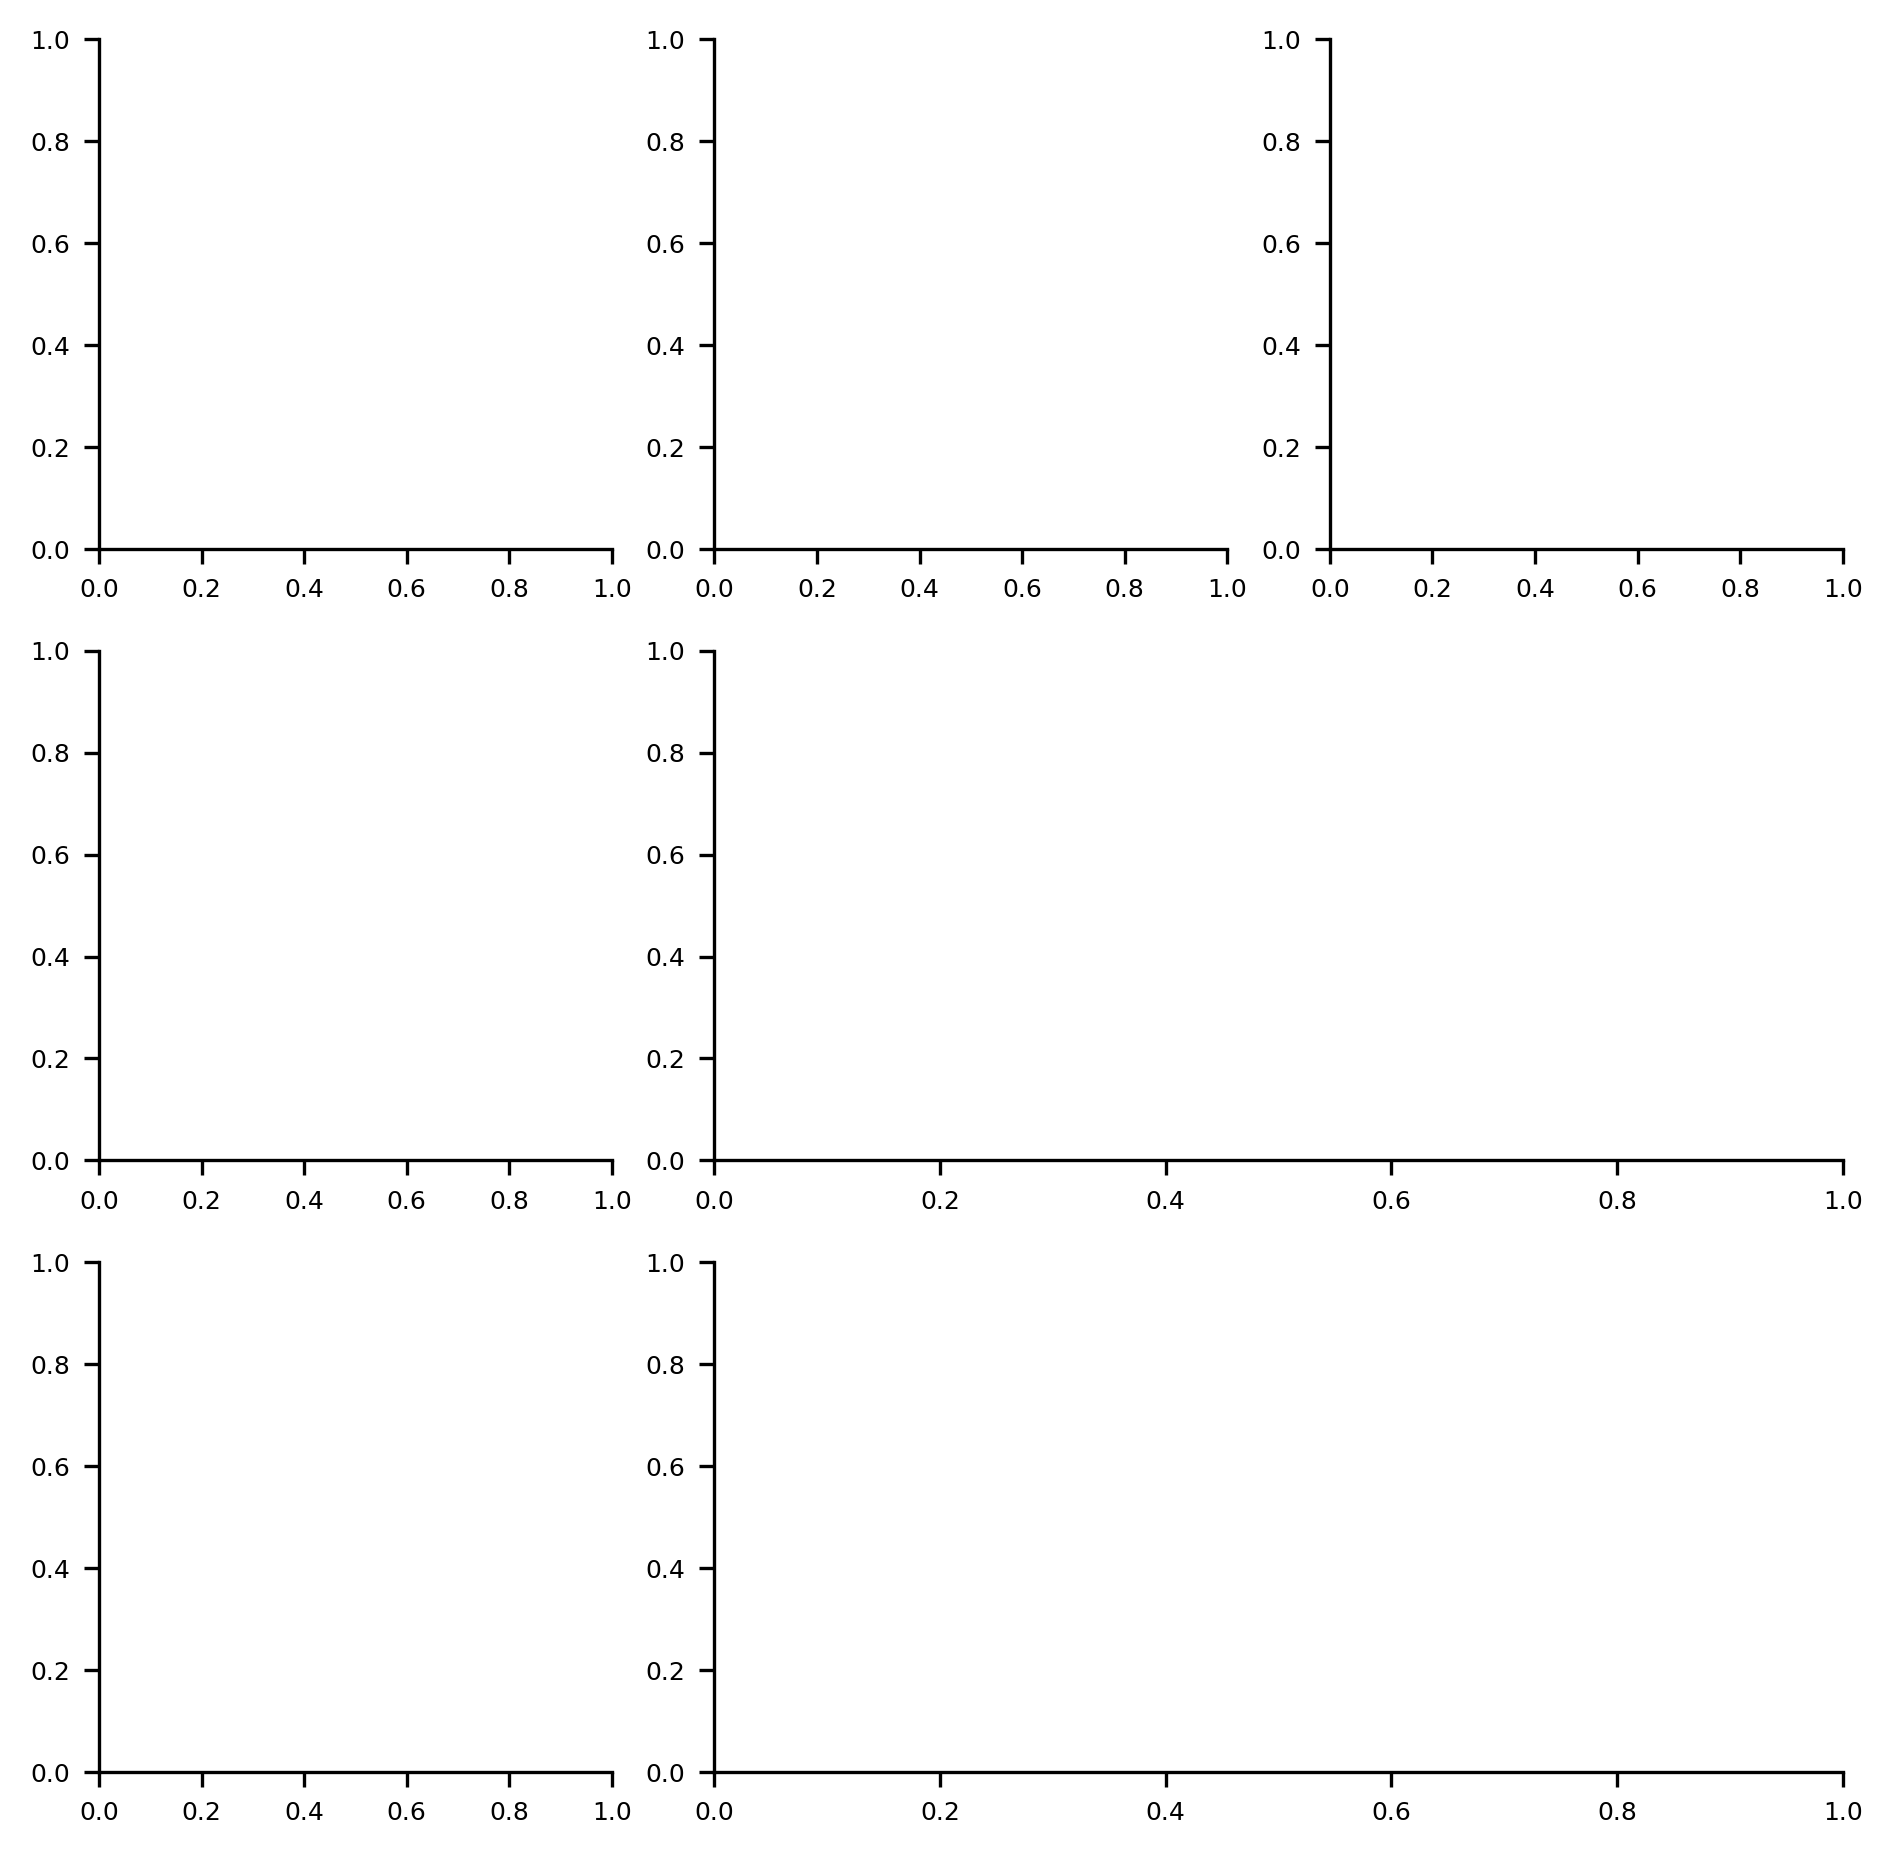

In [4]:
mosaic = [["A", "B", "C"], ["D", "E", "E"], ["F", "G", "G"]]
fig, axs = plot_helpers.create_pannels(mosaic=mosaic, h_pad=0)

In [5]:
menstrual_cycle = pickle.load(open(DATA_FOLDER + "menstrual_cycle_results.pkl", "rb"))

In [6]:
def get_gene_fractions(gene_name, adata, layer="total"):
    library_size = adata.layers[layer].sum(axis=1)
    library_size = np.array(library_size).flatten()
    gene_fractions = (
        adata[:, gene_name].layers[layer].toarray().flatten() / library_size
    )
    return gene_fractions


def plot_gene_profiles(
    gene_names,
    adata,
    inferred_phase,
    axs,
    position,
    GT_phase=None,
    layer="total",
    hue=None,
    phase_label="Inferred",
    legend_title=None,
):
    if type(axs[position]) is not list:
        axs = plot_helpers.replace_mosaic_cell_with_grid(
            fig, axs, label=position, nrows=1, ncols=len(gene_names)
        )
    for i in range(len(gene_names)):
        gene_name = gene_names[i]
        gene_fractions = get_gene_fractions(gene_name, adata, layer=layer)
        plotting.modify_axis_labels(ax=axs[position][i], step=0.5)

        plotting.plot_smoothed_profiles(
            inferred_phase,
            np.log(gene_fractions * 1e4 + 1),
            ax=axs[position][i],
            nbins=20,
            xlabel="Inferred Phase",
            ylabel=f"Normalized Counts (log)" if i == 0 else None,
            title=f"{gene_name} Profile",
            label=(
                phase_label
                if (i == len(gene_names) - 1 and GT_phase is not None)
                else None
            ),
            legend=i == len(gene_names) - 1,
            hue=hue,
            add_end_start_points=True,
        )
        axs[position][i].set_title(
            f"{gene_name}", fontstyle="italic", fontweight="bold"
        )
        if i == len(gene_names) - 1 and legend_title is not None:
            axs[position][i].legend(title=legend_title)

In [7]:
menstrual_cycle

{'adata_stromal_tot': AnnData object with n_obs × n_vars = 122144 × 33578
     obs: 'n_genes', 'sample', 'library', 'Processing', 'Treatment', '10x kit', 'percent_mito', 'n_counts', 'scrublet_score', 'genotype', 'Library_genotype', 'Group', 'discard_lowQC', 'Endometriosis_stage', 'Hormonal treatment', 'Age', 'Binary Stage', 'Stage', 'phase', 'dataset', 'Biopsy_type', 'Tissue_sampled', 'LT_celltype', 'LT_epi_celltype', 'LT_mesen_celltype', 'Endometrial_pathology', 'celltype', 'lineage', 'label_long', 'inferred_theta', 'has_endometriosis', 'Endometriosis_stage_grouped'
     var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'n_cells-15', 'gene_ids-16', 'feature_types-

In [8]:
adata = menstrual_cycle["adata_stromal_tot"]
thetas = menstrual_cycle["thetas_tot"]

<Axes: ylabel='Density'>

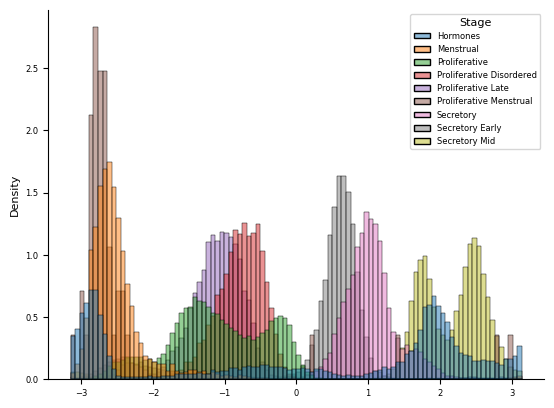

In [9]:
thetas_aligned = utils.normalize_angles(-thetas - 1 / 4 * np.pi)
sns.histplot(
    adata.obs,
    x=thetas_aligned,
    hue="Stage",
    stat="density",
    bins=100,
    common_norm=False,
)

In [10]:
thetas = thetas_aligned

In [11]:
# remove hormonal treatment
i = adata.obs["Hormonal treatment"] == "nan"
ax = axs["A"]
plotting.modify_axis_labels(ax=ax, step=0.5)
adata.obs["Annotated Stage"] = adata.obs["Binary Stage"]
sns.histplot(
    adata.obs[i],
    x=thetas[i],
    hue="Annotated Stage",
    stat="density",
    bins=30,
    common_norm=False,
    hue_order=["Menstrual", "Proliferative", "Secretory"],
    palette="Dark2",
    ax=ax,
    element="poly",
)
ax.set_title("Inferred Cycle Phase")
ax.set_xlabel("Inferred Phase")

Text(0.5, 1236.2745098039215, 'Inferred Phase')

In [12]:
adata.obs["celltype"].cat.categories

Index(['eStromal_MMPs', 'eStromal', 'eStromal_cycling', 'dStromal_early',
       'dStromal_mid', 'dStromal_late'],
      dtype='object')

In [13]:
ax = axs["B"]
plotting.modify_axis_labels(ax=ax, step=0.5)
adata.obs["Cell State"] = adata.obs["celltype"]
categories = adata.obs["Cell State"].cat.categories
map_categories = {
    "eStromal_MMPs": "eMMP",
    "eStromal": "eStr",
    "eStromal_cycling": "eCyc",
    "dStromal_early": "dEarly",
    "dStromal_mid": "dMid",
    "dStromal_late": "dLate",
}
categories = [map_categories[cat] for cat in categories]
adata.obs["Cell State"] = adata.obs["Cell State"].map(map_categories)

sns.histplot(
    adata.obs,
    x=thetas,
    hue="Cell State",
    stat="density",
    bins=30,
    common_norm=False,
    element="poly",
    ax=ax,
    hue_order=categories,
)
ax.set_xlabel("Inferred Phase")
sns.move_legend(ax, title="", loc="best")
# move legend at 20% of the x axis and 100% of the y axis

In [14]:
menstrual_cycle.keys()

dict_keys(['adata_stromal_tot', 'thetas_tot', 'z_space', 'fourier_coefficients', 'small_obs', 'variable_genes', 'seed_genes'])

In [16]:
small_obs = menstrual_cycle["small_obs"]
small_obs["Cell Type"] = small_obs["celltype"]
plotting.plot_z_space_paper(
    z_1=menstrual_cycle["z_space"][:, 0],
    z_2=menstrual_cycle["z_space"][:, 1],
    ax=axs["C"],
    hue=small_obs["Cell Type"],
    legend=True,
    xlabel="UMAP 1",
    ylabel="UMAP 2",
)
handles, labels = axs["C"].get_legend_handles_labels()
# Keep only first occurrence of each label
seen, new_h, new_l = set(), [], []
for h, l in zip(handles, labels):
    if l not in seen and l in ("eStromal_cycling", "Other"):
        l = l.replace("_", " ")
        seen.add(l)
        new_h.append(h)
        new_l.append(l)
        h.set_alpha(1)

axs["C"].legend(new_h, new_l, title="", fontsize="small", title_fontsize="small")

In [17]:
mean_expression = (
    adata[:, menstrual_cycle["variable_genes"]].layers["total"].mean(axis=0)
)

In [19]:
df_fourrier = pd.DataFrame(
    menstrual_cycle["fourier_coefficients"],
    index=menstrual_cycle["variable_genes"],
    columns=["Cos1", "Sin1", "Cos2", "Sin2", "Cos3", "Sin3"],
)
df_fourrier["Amplitude1"] = np.sqrt(df_fourrier["Cos1"] ** 2 + df_fourrier["Sin1"] ** 2)
df_fourrier["Amplitude2"] = np.sqrt(df_fourrier["Cos2"] ** 2 + df_fourrier["Sin2"] ** 2)
df_fourrier["Amplitude3"] = np.sqrt(df_fourrier["Cos3"] ** 2 + df_fourrier["Sin3"] ** 2)
df_fourrier["Mean_Expression"] = np.array(mean_expression).flatten()
df_fourrier["Score1"] = (
    np.log(1 + df_fourrier["Amplitude1"]) * df_fourrier["Mean_Expression"]
)
df_fourrier["Score2"] = (
    np.log(1 + df_fourrier["Amplitude2"]) * df_fourrier["Mean_Expression"]
)
df_fourrier["Score3"] = (
    np.log(1 + df_fourrier["Amplitude3"]) * df_fourrier["Mean_Expression"]
)
df_fourrier = df_fourrier.sort_values("Score1", ascending=False)

df_fourrier

,Cos1,Sin1,Cos2,Sin2,Cos3,Sin3,Amplitude1,Amplitude2,Amplitude3,Mean_Expression,Score1,Score2,Score3
KCNIP4,2.462063,-0.403428,-0.016615,0.194595,-0.225355,-0.102505,2.494897,0.195303,0.247572,31.436304,39.336365,5.608227,6.953692
RORA,-0.745853,-0.228394,0.382531,0.104208,-0.274361,0.042268,0.780038,0.396471,0.277597,17.424286,10.047453,5.818816,4.268624
LSAMP,0.800407,-0.522170,0.081335,0.062175,-0.147942,0.145955,0.955674,0.102378,0.207821,12.941807,8.680523,1.261431,2.443648
PLCL1,-1.451647,-0.837783,-0.099187,-0.002511,0.022410,0.204102,1.676055,0.099218,0.205328,7.526747,7.408906,0.712025,1.405636
SFRP4,1.688394,-0.158663,-0.228057,0.334257,-0.105743,-0.006706,1.695833,0.404645,0.105956,6.828661,6.772032,2.320276,0.687714
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRAJ47,0.236953,0.223005,-0.996605,0.555321,0.884224,-1.190520,0.325389,1.140879,1.482967,0.000098,0.000028,0.000075,0.000089
AC093534.2,-0.332805,-0.613982,-1.101004,0.438694,0.663252,0.787809,0.698379,1.185184,1.029828,0.000049,0.000026,0.000038,0.000035
CCDC70,-0.028888,0.228553,-0.792139,-0.027908,0.918067,-0.515476,0.230371,0.792631,1.052883,0.000115,0.000024,0.000067,0.000082
AC012301.2,-0.145425,-0.278766,1.004836,1.099396,-0.440663,-0.918594,0.314419,1.489418,1.018822,0.000082,0.000022,0.000075,0.000058


In [20]:
adata.var_names[adata.var_names.str.startswith("LHF")]

Index(['LHFPL1', 'LHFPL2', 'LHFPL3', 'LHFPL3-AS1', 'LHFPL3-AS2', 'LHFPL4',
       'LHFPL5', 'LHFPL6'],
      dtype='object')

In [21]:
menstrual_cycle.keys()

dict_keys(['adata_stromal_tot', 'thetas_tot', 'z_space', 'fourier_coefficients', 'small_obs', 'variable_genes', 'seed_genes'])

In [22]:
df_fourrier = df_fourrier.loc[menstrual_cycle["seed_genes"]].copy()

In [23]:
# plot df fourrier on a circular plot

plot_helpers.make_polar(axs, "D")
ax = axs["D"]
# set 0 to top
ax.set_theta_zero_location("N")
# set clockwise
ax.set_theta_direction(-1)
ax.scatter(
    utils.normalize_angles(
        (-np.arctan2(df_fourrier["Sin1"], df_fourrier["Cos1"]) - 1 / 4 * np.pi) + np.pi
    ),
    df_fourrier["Amplitude1"],
    s=df_fourrier["Mean_Expression"],
    alpha=0.7,
)
for genes in [
    "MTUS2",
    "MMP11",
    "CXCL14",
    "SGIP1",
    # "HCN1",
    "PAEP",
    "LHFPL3",
    "KCNIP4-IT1",
    # "SCGB1D2",
]:
    angle = utils.normalize_angles(
        (
            -np.arctan2(df_fourrier.loc[genes, "Sin1"], df_fourrier.loc[genes, "Cos1"])
            - 1 / 4 * np.pi
        )
        + np.pi
    )
    radius = df_fourrier.loc[genes, "Amplitude1"]
    ax.text(
        angle,
        radius,
        genes,
        fontsize=constants.TINY_SIZE,
        ha="center",
        va="center",
        rotation_mode="anchor",
    )
# set ylabel to 1,2,3
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(["", "", ""])
ax.set_xticks(np.pi / 3 * np.arange(6))
ax.set_xticklabels([""] * 6)
# add extra rings for menstrual cycle phases

colors = sns.color_palette("Dark2", 3)
r_max = np.nanmax(df_fourrier["Amplitude1"])
r0 = r_max + 0.15  # ring center radius
h = 0.1  # ring thickness
# 0 from 0 to π/2
ax.bar(
    x=0,
    height=h,
    width=np.pi / 2,
    bottom=r0,
    color=colors[0],
    edgecolor="none",
    align="edge",
    label="Menstrual",
)
# 1 from π/2 to π
ax.bar(
    x=np.pi / 2,
    height=h,
    width=np.pi / 2,
    bottom=r0,
    color=colors[1],
    edgecolor="none",
    align="edge",
    label="Proliferative",
)
# 2 from π to 2π
ax.bar(
    x=np.pi,
    height=h,
    width=np.pi,
    bottom=r0,
    color=colors[2],
    edgecolor="none",
    align="edge",
    label="Secretory",
)
ax.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))

In [24]:
df_fourrier = df_fourrier.sort_values("Score3", ascending=False)
df_fourrier

,Cos1,Sin1,Cos2,Sin2,Cos3,Sin3,Amplitude1,Amplitude2,Amplitude3,Mean_Expression,Score1,Score2,Score3
KCNIP4,2.462063,-0.403428,-0.016615,0.194595,-0.225355,-0.102505,2.494897,0.195303,0.247572,31.436304,39.336365,5.608227,6.953692
RORA,-0.745853,-0.228394,0.382531,0.104208,-0.274361,0.042268,0.780038,0.396471,0.277597,17.424286,10.047453,5.818816,4.268624
LSAMP,0.800407,-0.522170,0.081335,0.062175,-0.147942,0.145955,0.955674,0.102378,0.207821,12.941807,8.680523,1.261431,2.443648
JAZF1,-0.062798,-0.850543,0.183847,0.304548,-0.145881,0.207095,0.852858,0.355738,0.253317,10.594691,6.534057,3.224449,2.392217
NLGN1,0.634455,-0.257395,0.190069,0.144268,-0.177175,0.009402,0.684679,0.238620,0.177424,9.936698,5.182733,2.126434,1.622951
...,...,...,...,...,...,...,...,...,...,...,...,...,...
CPM,1.169407,0.133597,0.082645,0.619751,-0.141860,-0.078169,1.177013,0.625237,0.161971,0.618933,0.481502,0.300587,0.092913
BTBD11,1.461867,-0.364618,0.109185,0.253057,-0.074483,0.004654,1.506653,0.275607,0.074628,1.172739,1.077686,0.285470,0.084408
NNMT,-2.259307,-0.316433,-0.171208,-0.051546,-0.167324,0.209924,2.281358,0.178799,0.268450,0.317846,0.377683,0.052284,0.075582
SERPING1,-1.250736,0.329698,0.232287,0.126262,-0.128182,-0.045697,1.293461,0.264385,0.136084,0.532503,0.442010,0.124917,0.067940


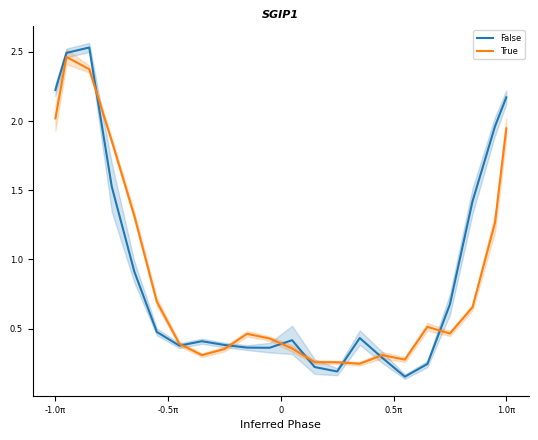

In [25]:
def plot_gene_profile(gene_name, ax, layer="total", hue=None):
    gene_fractions = get_gene_fractions(gene_name, adata, layer=layer)
    plotting.modify_axis_labels(ax=ax, step=0.5)

    plotting.plot_smoothed_profiles(
        thetas,
        np.log(gene_fractions * 1e4 + 1),
        ax=ax,
        nbins=20,
        xlabel="Inferred Phase",
        add_end_start_points=True,
        hue=hue,
    )
    ax.set_title(f"{gene_name}", fontstyle="italic", fontweight="bold")


plot_gene_profile(
    "SGIP1", layer="total", ax=plt.gca(), hue=adata.obs["Endometriosis_stage"] != "0"
)

In [26]:
plot_gene_profiles(
    gene_names=["MMP11", "CXCL14", "SGIP1"],
    adata=adata,
    inferred_phase=thetas,
    axs=axs,
    position="E",
    layer="total",
    hue=adata.obs["Endometriosis_stage"] != "0",
    phase_label="Inferred",
    legend_title="Endometriosis",
)

In [27]:
adata.obs.columns

Index(['n_genes', 'sample', 'library', 'Processing', 'Treatment', '10x kit',
       'percent_mito', 'n_counts', 'scrublet_score', 'genotype',
       'Library_genotype', 'Group', 'discard_lowQC', 'Endometriosis_stage',
       'Hormonal treatment', 'Age', 'Binary Stage', 'Stage', 'phase',
       'dataset', 'Biopsy_type', 'Tissue_sampled', 'LT_celltype',
       'LT_epi_celltype', 'LT_mesen_celltype', 'Endometrial_pathology',
       'celltype', 'lineage', 'label_long', 'inferred_theta',
       'has_endometriosis', 'Endometriosis_stage_grouped', 'Annotated Stage',
       'Cell State'],
      dtype='object')

In [28]:
adata.obs["Annotated Stage"].isin(["Proliferative", "Menstrual"])

UA_Endo11596521_GAACACTCAGAGAAAG     True
UA_Endo12449301_TCAGTGATCGTAGGGA     True
UA_Endo10281925_AGGTAGGTCCTCACTG     True
UA_Endo11173482_TATTTCGGTGCCTGCA    False
UA_Endo10281925_AGCGTATCAGAAGTTA     True
                                    ...  
UA_Endo12865961_CACTGGGAGGCATCGA    False
UA_Endo10281926_CCCTTAGCACATGGTT     True
UA_Endo11460963_GTAGGAGAGTGGATAT    False
UA_Endo11460960_GAAGGACGTCCCTCAT    False
UA_Endo12865963_AGGCATTAGTGCAGGT    False
Name: Annotated Stage, Length: 122144, dtype: bool

In [29]:
len(np.unique(adata.obs[i]["genotype"]))

47

In [30]:
# get proportions of celltypes per genotype
i = adata.obs["Annotated Stage"].isin(["Proliferative", "Menstrual"])
df_to_plot = adata.obs[i].groupby("genotype")["celltype"].value_counts(normalize=True)
df_to_plot = df_to_plot.unstack().fillna(0)
# drop those with less than 5% in both cell types
df_to_plot = df_to_plot[
    (df_to_plot["eStromal"] > 0.05) | (df_to_plot["eStromal_MMPs"] > 0.05)
]
# renormalize to only those two cell types
df_to_plot = df_to_plot[["eStromal", "eStromal_MMPs"]]
df_to_plot = df_to_plot.div(df_to_plot.sum(axis=1), axis=0)
ax = axs["F"]
sns.histplot(
    x=df_to_plot["eStromal_MMPs"],
    ax=ax,
    bins=20,
    alpha=0.8,
)
ax.set_xlabel("Proportion of eStromal MMPs")
ax.set_ylabel("# Patients")
ax.set_title("eStromal MMPs/eStromal Fraction")

/tmp/ipykernel_1480901/634642776.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_to_plot = adata.obs[i].groupby("genotype")["celltype"].value_counts(normalize=True)


Text(0.5, 1.0, 'eStromal MMPs/eStromal Fraction')

In [31]:
plot_gene_profiles(
    gene_names=["GREB1", "DKK1", "PAEP"],
    adata=adata,
    inferred_phase=thetas,
    axs=axs,
    position="G",
    layer="total",
    hue=adata.obs["Endometriosis_stage"] != "0",
    legend_title="Endometriosis",
)

In [33]:
plot_helpers.label_panels_mosaic(fig, axs, mosaic)

Figure saved to: /home/maxine/Documents/paychere/cell_cycle_VAE_Fourrier_model/paper/figures/figure_6_menstrual_cycle_python.svg


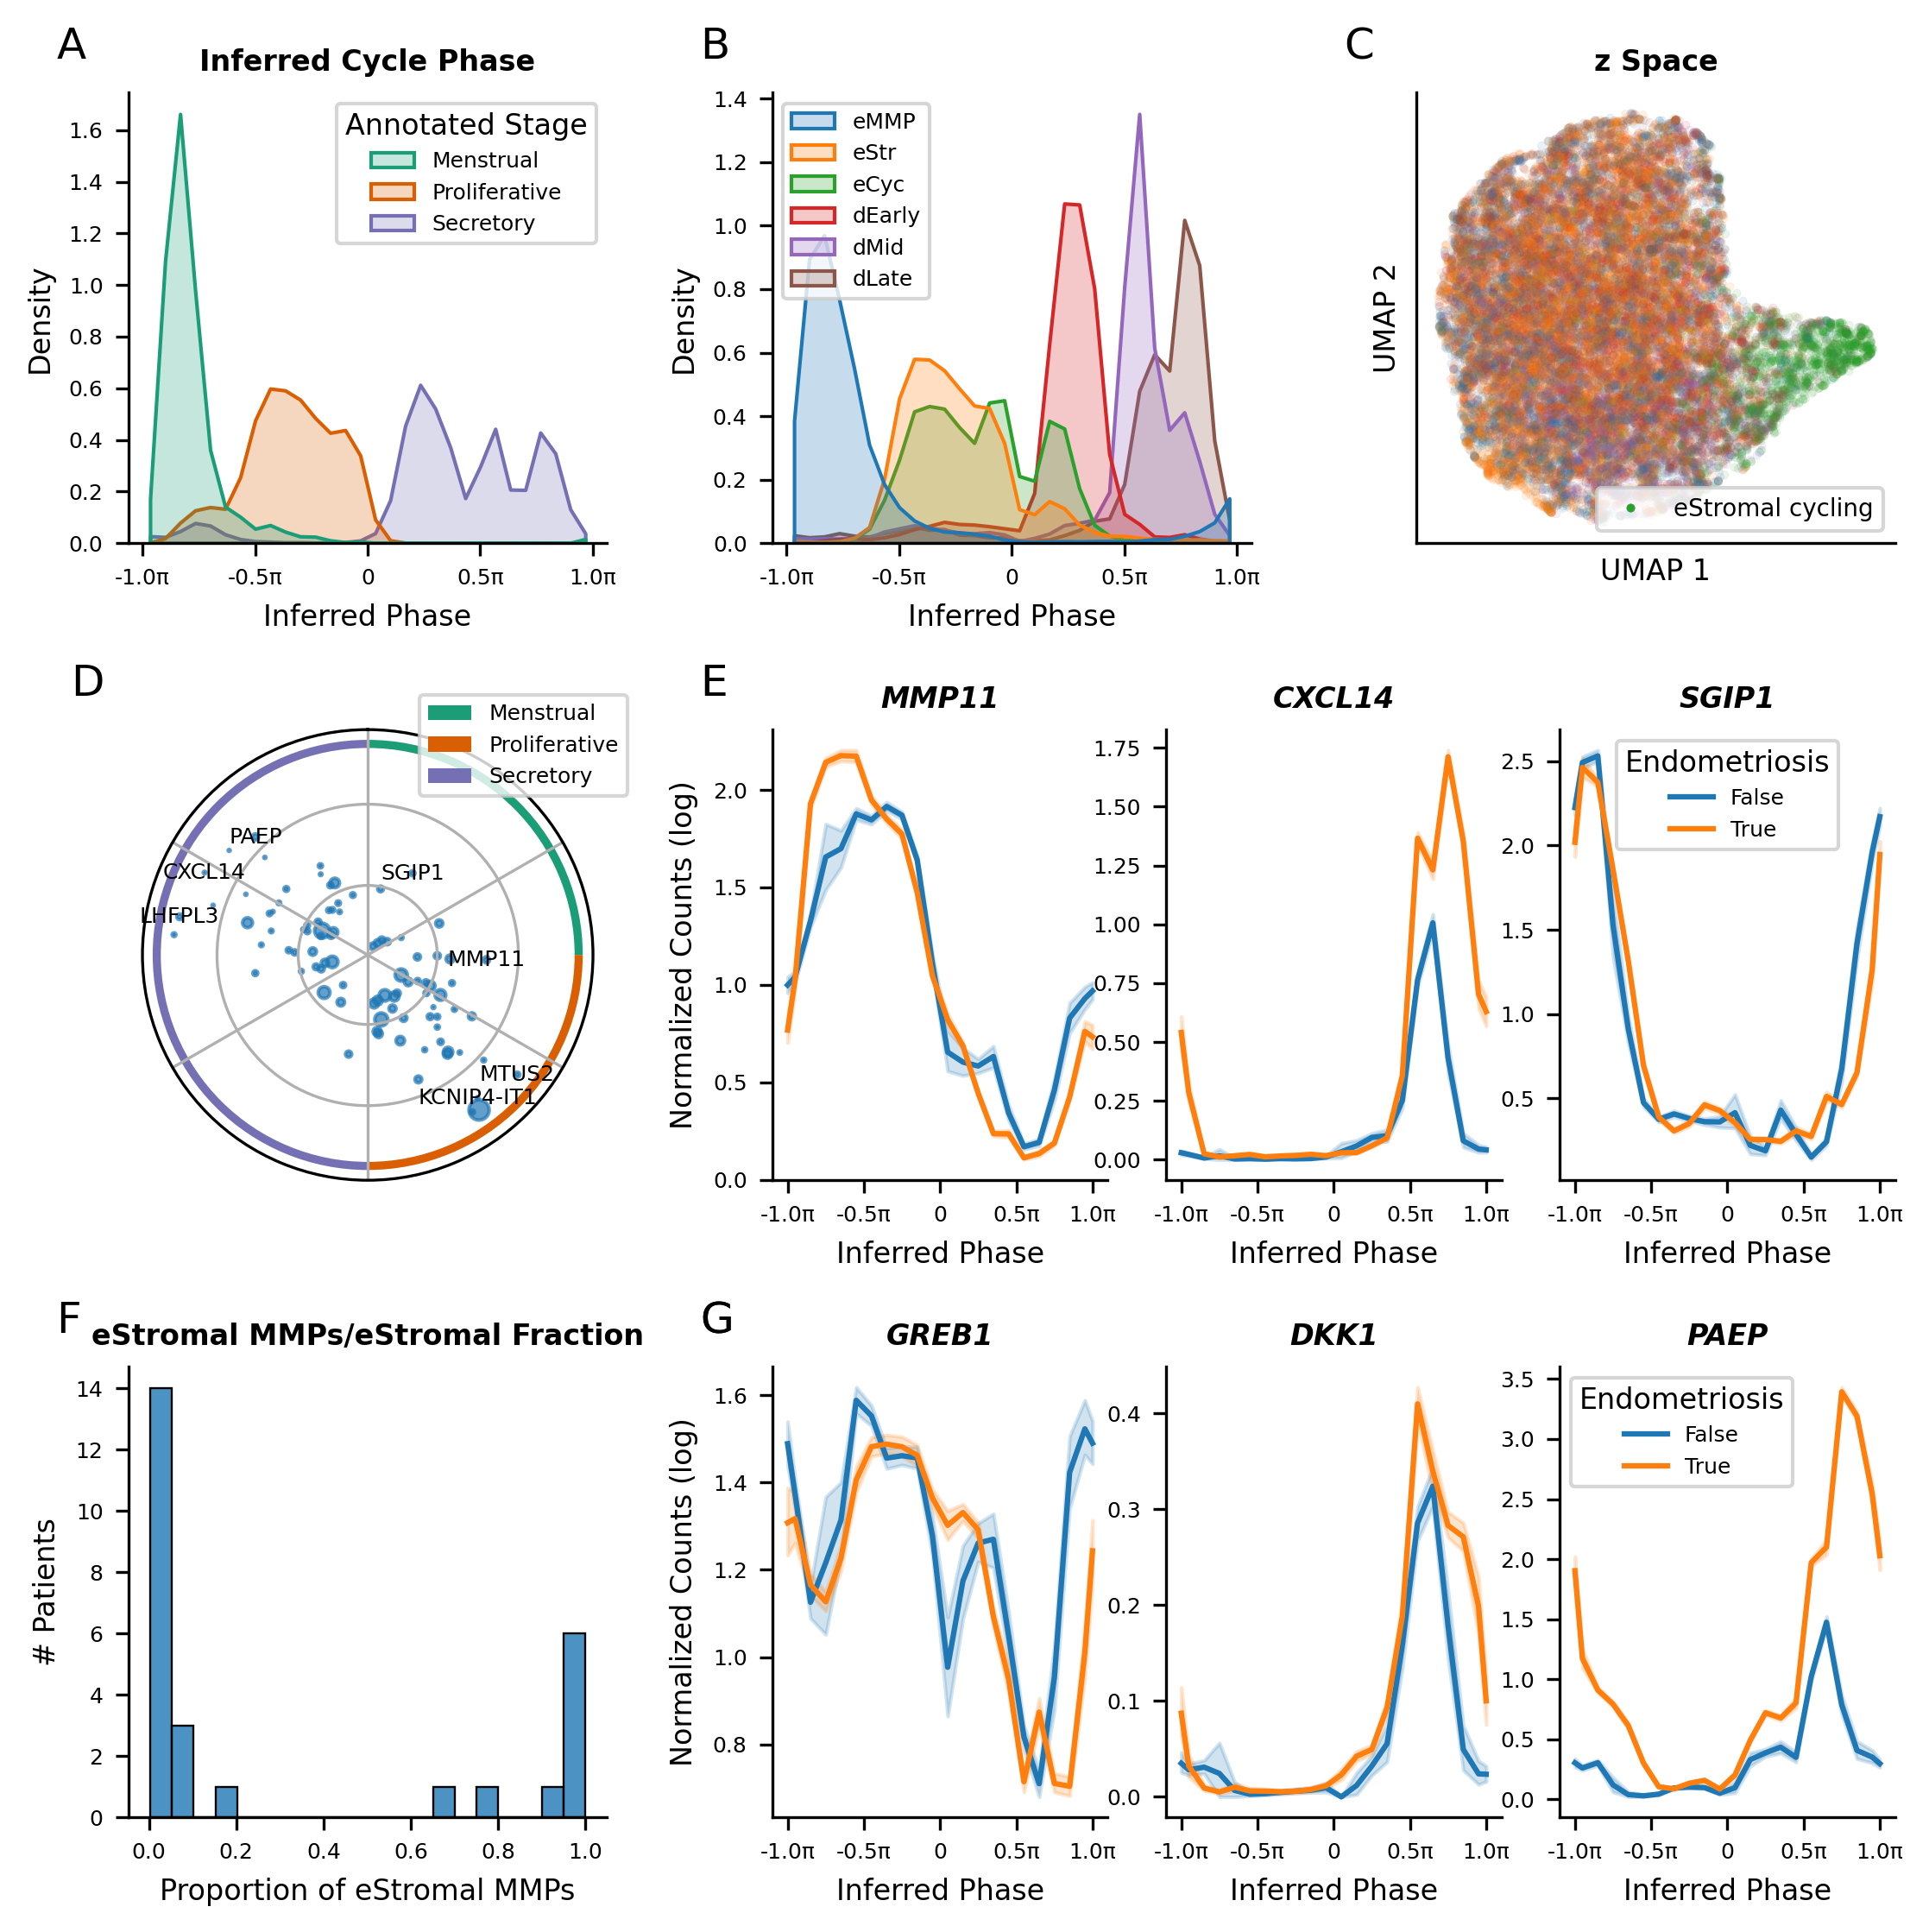

In [ ]:
plot_helpers.save_figure(fig, axs, "figure_5_menstrual_cycle_python")